# Sentiment Analysis, IMDB Challenge.

This is a dataset for binary sentiment classification. It contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

See the README file contained in the release for more details.
If the .sh script doesn't work (wrong dependencies, or Windows system), manually download your dataset at https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

For further information about state of the art results, check out [link](http://nlpprogress.com/english/sentiment_analysis.html)

### Guidelines

Your goal is to establish a sentiment analysis model on the well known IMDB dataset. Label is either *positive* (1) or *negative* (0). The dataset contains a train and a test set. 

The technical approach is completely open. Your model's performances will be assessed based on the accuracy on this test set.

A few guidelines : 

- Various approaches can imagined, from simple Machine Learning algorithm to elaborated Deep Learning networks. Data preparation choices can also be crucial.
- The folder *unsup* contains some unlabelled data, that might useful for various matters
- Try to first establish a super simple baseline, before diving into sophisticated models
- Comment all your explorations to explain your technical choices.

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


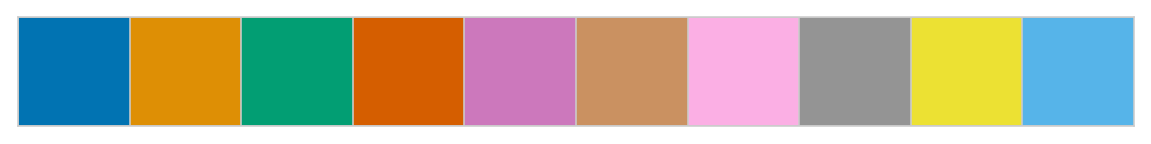

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 14})
import seaborn as sns
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("colorblind"))
import os
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, RepeatVector, TimeDistributed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import OneHotEncoder
import gensim
from google.colab import drive
drive.mount('/content/gdrive')

# Download dataset

In [1]:
# !wget -P /content/gdrive/My\ Drive/data/dataset https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-06-03 08:41:25--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.3’

aclImdb_v1.tar.gz.3 100%[===================>]  80.23M  20.5MB/s    in 7.1s    

2019-06-03 08:41:33 (11.3 MB/s) - ‘aclImdb_v1.tar.gz.3’ saved [84125825/84125825]



In [0]:
# !tar -xf /content/gdrive/My\ Drive/data/dataset/aclImdb_v1.tar.gz -C /content/gdrive/My\ Drive/data/dataset
!tar -xf aclImdb_v1.tar.gz

# Load dataset into Dataframe and regex cleaning

In [0]:
# path = "/content/gdrive/My Drive/data/dataset/aclImdb"
path = "./aclImdb"
train_pos_dirs = [os.path.join(path+"/train"+"/pos", files) for files in os.listdir(path+"/train"+"/pos")]
train_neg_dirs = [os.path.join(path+"/train"+"/neg", files) for files in os.listdir(path+"/train"+"/neg")]
test_pos_dirs = [os.path.join(path+"/test"+"/pos", files) for files in os.listdir(path+"/test"+"/pos")]
test_neg_dirs = [os.path.join(path+"/test"+"/neg", files) for files in os.listdir(path+"/test"+"/neg")]

In [0]:
train_pos = [open(file, "r").read() for file in train_pos_dirs]
train_neg = [open(file, "r").read() for file in train_neg_dirs]
test_pos = [open(file, "r").read() for file in test_pos_dirs]
test_neg = [open(file, "r").read() for file in test_neg_dirs]

In [7]:
print(train_pos[3])

There seems to be only two types of reviews of this film on the net. Those who hate it and curse Ralph Bakshis name and those love it and call it work of genious. I'm inclined to be in the middle. I'am forced to agree with most of the criticisms of this film (e.g.the cruel cutting of the story, badly rotoscoped charecters, over acting etc...) But dispite this I still love this film. The rotoscoping (when done properly)adds an eerie lifelike dimension to the charecters and the final battle scene at the end of the film is fantastic. The surrealistic scenes when the nineriders chase Frodo are stylish and well executed and the musical score... magic. Sadly the bad points outweight film but if you can bring yourself to ignore them it is a great film.<br /><br />(No doubt I'll be lynched by an angry mob of people who hate this film after writing this review, ah well, such is life)


In [0]:
replacements = [
    (r"(<br />)+", " "),
    (r"\\", ""),
    (r"!|\*|\?|,|\.|;|&|\$|\(|\)", "")
]
for old, new in replacements:
    train_pos = [re.sub(old, new, review) for review in train_pos]
    train_neg = [re.sub(old, new, review) for review in train_neg]
    test_pos = [re.sub(old, new, review) for review in test_pos]
    test_neg = [re.sub(old, new, review) for review in test_neg]

In [9]:
print(train_pos[3])

There seems to be only two types of reviews of this film on the net Those who hate it and curse Ralph Bakshis name and those love it and call it work of genious I'm inclined to be in the middle I'am forced to agree with most of the criticisms of this film egthe cruel cutting of the story badly rotoscoped charecters over acting etc But dispite this I still love this film The rotoscoping when done properlyadds an eerie lifelike dimension to the charecters and the final battle scene at the end of the film is fantastic The surrealistic scenes when the nineriders chase Frodo are stylish and well executed and the musical score magic Sadly the bad points outweight film but if you can bring yourself to ignore them it is a great film No doubt I'll be lynched by an angry mob of people who hate this film after writing this review ah well such is life


In [0]:
df_train = pd.DataFrame({"review": train_pos+train_neg,
                         "label": np.hstack((np.ones(len(train_pos), dtype=np.int8), np.zeros(len(train_neg), dtype=np.int8)))})
df_test = pd.DataFrame({"review": test_pos+test_neg,
                        "label": np.hstack((np.ones(len(test_pos), dtype=np.int8), np.zeros(len(test_neg), dtype=np.int8)))})


In [11]:
df_train.head(2)

,review,label
0,Though not in the whole film Andy Griffith aga...,1
1,It is no surprise that writer/director Michael...,1


In [12]:
df_test.head(2)

,review,label
0,I absolutely love this film Everything about i...,1
1,Set in and near a poor working class town in t...,1


# Data visualisation and remove outliers

In [0]:
df_train["length"] = df_train.apply(lambda row: len(row["review"]), axis=1)
df_test["length"] = df_test.apply(lambda row: len(row["review"]), axis=1)

In [14]:
df_train.head(2)

,review,label,length
0,Though not in the whole film Andy Griffith aga...,1,350
1,It is no surprise that writer/director Michael...,1,4458


In [15]:
df_test.head(2)

,review,label,length
0,I absolutely love this film Everything about i...,1,347
1,Set in and near a poor working class town in t...,1,1980


In [16]:
print(df_train.shape)
print(df_test.shape)

(25000, 3)
(25000, 3)


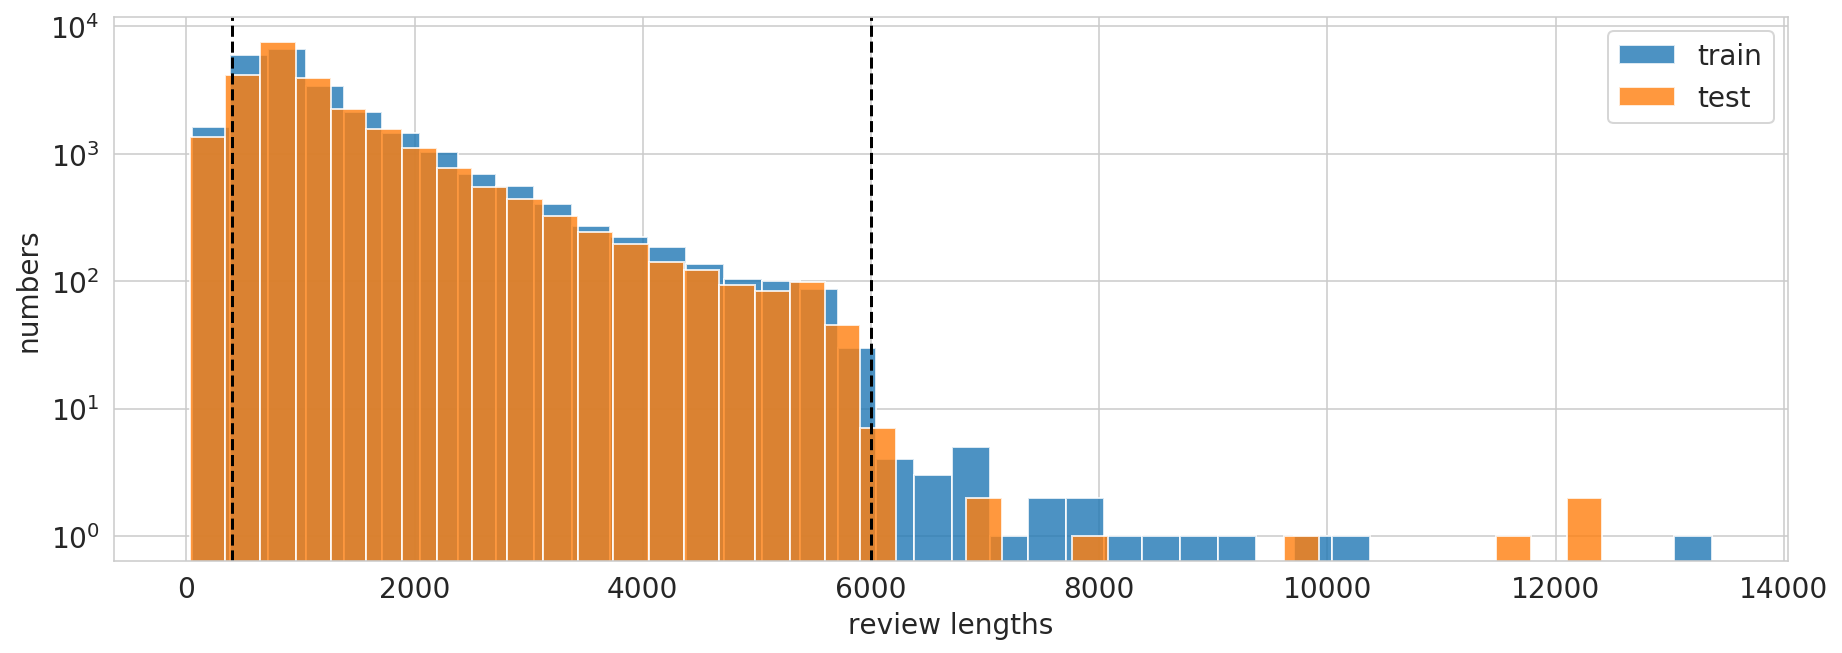

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_train["length"], label="train", alpha=.8, bins=40)
ax.hist(df_test["length"], label="test", alpha=.8, bins=40)
ax.axvline(400, color="black", ls="--")
ax.axvline(6000, color="black", ls="--")
plt.xlabel("review lengths")
plt.ylabel("numbers")
plt.legend()
plt.yscale("log")
plt.show()

In [0]:
df_train = df_train[df_train["length"].between(400, 6000, inclusive=True)]
df_test = df_test[df_test["length"].between(400, 6000, inclusive=True)]

In [19]:
print(df_train.shape)
print(df_test.shape)

(23222, 3)
(23139, 3)


Dataset is still balanced after outliers removal

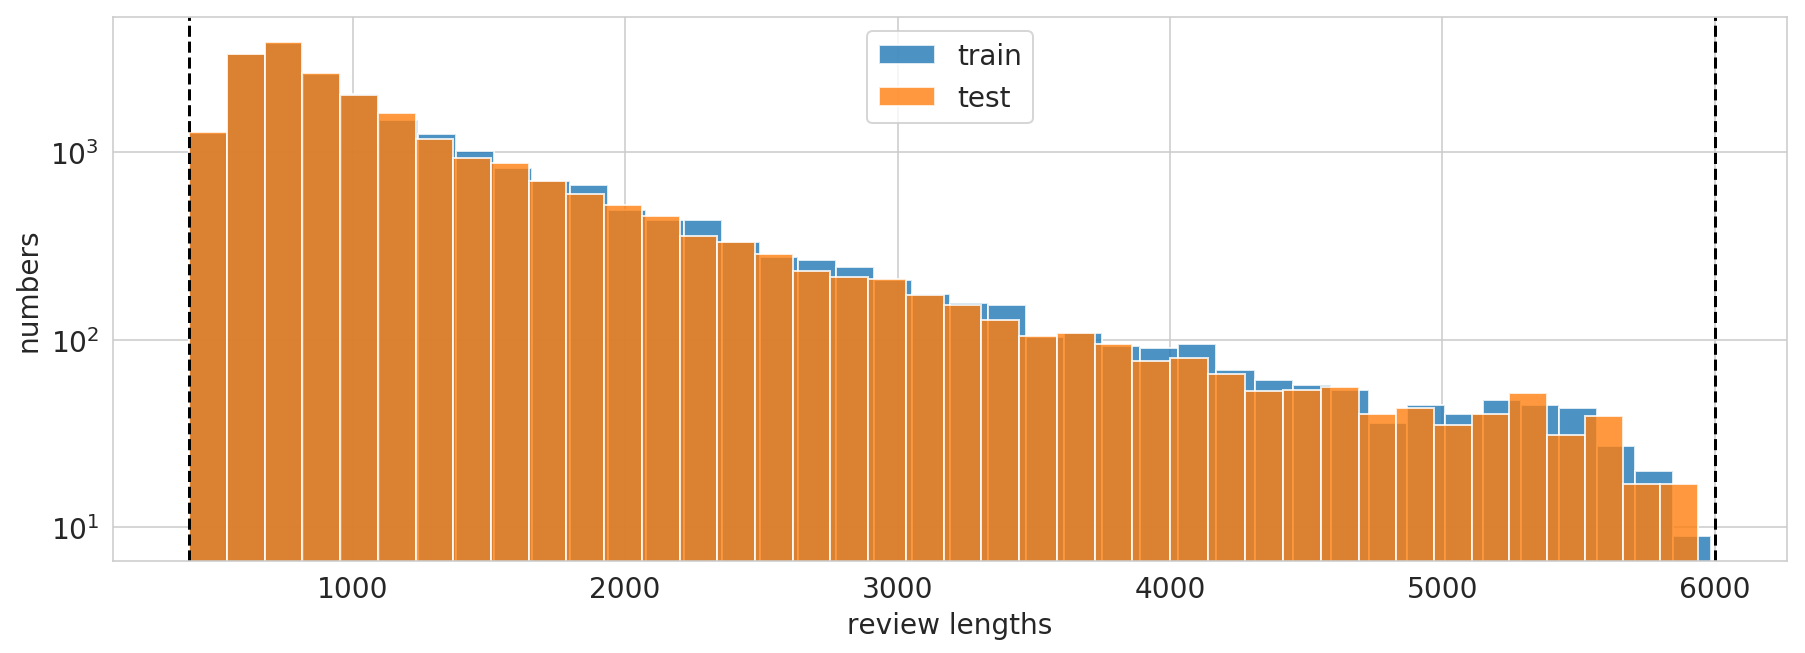

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_train["length"], label="train", alpha=.8, bins=40)
ax.hist(df_test["length"], label="test", alpha=.8, bins=40)
ax.axvline(400, color="black", ls="--")
ax.axvline(6000, color="black", ls="--")
plt.xlabel("review lengths")
plt.ylabel("numbers")
plt.legend()
plt.yscale("log")
plt.show()

# SVM model based on TF-IDF

In [0]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents="ascii", token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=.001)

In [0]:
vectorizer = vectorizer.fit(df_train["review"])

## Check resulting vocab and idf distribution

In [0]:
df_vocab = pd.DataFrame.from_dict({v : k for k, v in vectorizer.vocabulary_.items()}, orient="index", columns=["word"])

In [0]:
df_vocab.shape

(10440, 1)

In [0]:
df_vocab.head(2)

,word
4967,it
4955,is


In [0]:
df_vocab = df_vocab.sort_index()

In [0]:
df_vocab.head(2)

,word
0,a
1,abandon


In [0]:
df_vocab["idf"] = pd.Series(vectorizer.idf_)

In [0]:
df_vocab.head()

,word,idf
0,a,1.019963
1,abandon,7.101655
2,abandoned,5.893843
3,abc,6.646179
4,abducted,7.651701


### Least meaningfull words

In [0]:
df_vocab.sort_values(["idf"], ascending=True).head()

,word,idf
9367,the,1.002328
0,a,1.019963
343,and,1.021546
6414,of,1.033318
9501,to,1.039391


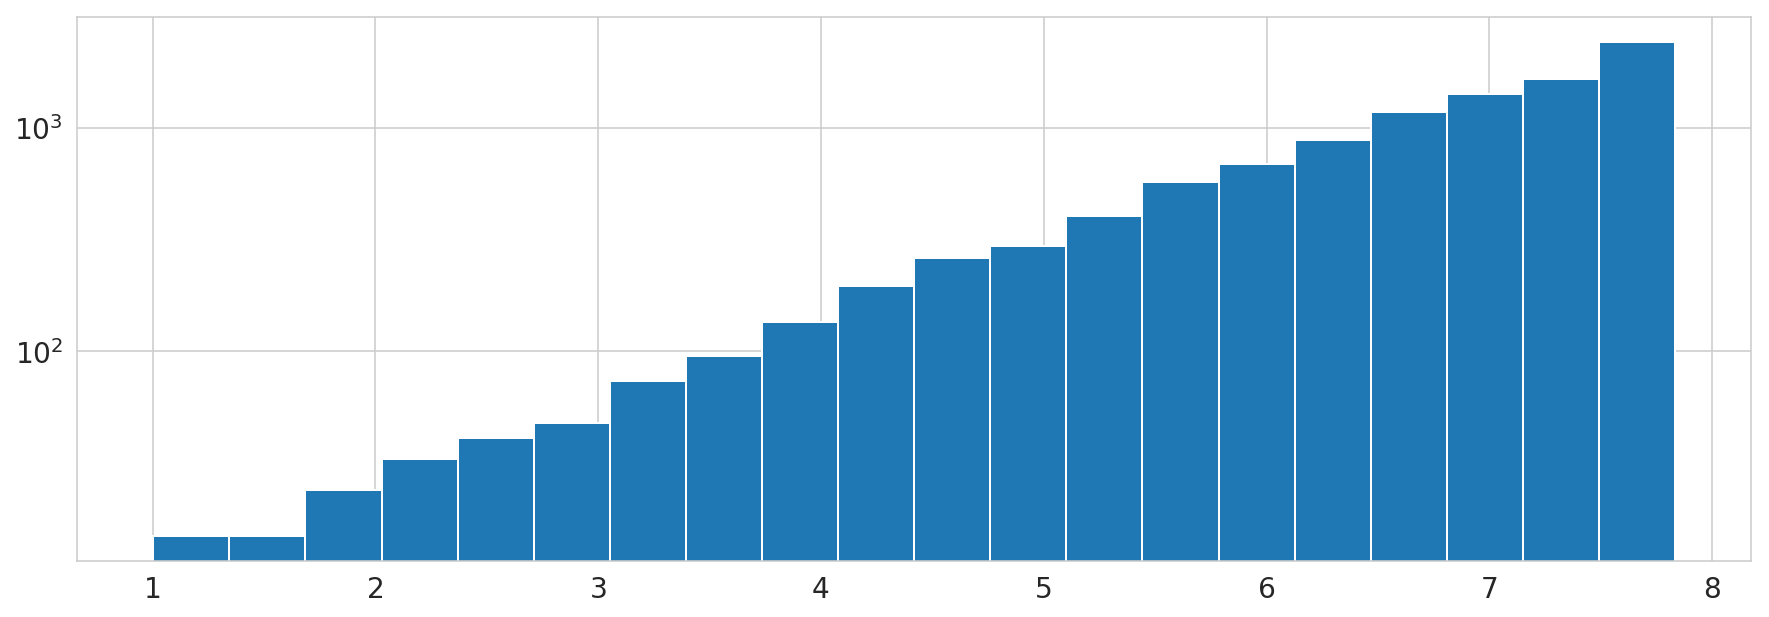

In [0]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_vocab["idf"], bins=20)
plt.yscale("log")
plt.show()

### Most meaningfull words

In [0]:
df_vocab.sort_values(["idf"], ascending=False).head()

,word,idf
9363,thankless,7.834023
256,alienate,7.834023
8017,sample,7.834023
838,believably,7.834023
6774,perkins,7.834023


In [0]:
X_train = vectorizer.transform(df_train["review"].values)

In [0]:
print(X_train[0].shape)

(1, 10440)


In [0]:
print(X_train.toarray().shape)

(23222, 10440)


In [0]:
y_train = df_train["label"].values

In [0]:
y_train.shape

(23222,)

In [0]:
X_test = vectorizer.transform(df_test["review"].values)

In [0]:
X_test.toarray().shape

(23139, 10440)

In [0]:
y_test = df_test["label"].values

In [0]:
y_test.shape

(23139,)

In [0]:
clf = SVC(gamma="auto", kernel="linear")

In [0]:
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Results

In [0]:
classification_report(y_train, clf.predict(X_train), output_dict=True)

{'0': {'f1-score': 0.9489904810688522,
  'precision': 0.9510609171800137,
  'recall': 0.9469290399522957,
  'support': 11739},
 '1': {'f1-score': 0.948081852543772,
  'precision': 0.9459857811687186,
  'recall': 0.9501872333014021,
  'support': 11483},
 'accuracy': 0.9485401774179657,
 'macro avg': {'f1-score': 0.9485361668063121,
  'precision': 0.9485233491743661,
  'recall': 0.948558136626849,
  'support': 23222},
 'weighted avg': {'f1-score': 0.9485411751798892,
  'precision': 0.9485513233974927,
  'recall': 0.9485401774179657,
  'support': 23222}}

In [0]:
classification_report(y_test, clf.predict(X_test), output_dict=True)

{'0': {'f1-score': 0.8828605604921395,
  'precision': 0.8792545949625595,
  'recall': 0.8864962251201098,
  'support': 11656},
 '1': {'f1-score': 0.880104940970704,
  'precision': 0.8838148766136823,
  'recall': 0.8764260210746321,
  'support': 11483},
 'accuracy': 0.8814987683132374,
 'macro avg': {'f1-score': 0.8814827507314218,
  'precision': 0.8815347357881209,
  'recall': 0.881461123097371,
  'support': 23139},
 'weighted avg': {'f1-score': 0.8814930520015114,
  'precision': 0.8815176881904364,
  'recall': 0.8814987683132374,
  'support': 23139}}

Average acc score for SVM model is 88,15%

# LSTM with untrained embedding layer

In [0]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)

In [0]:
tokenizer.fit_on_texts(df_train["review"].values)

In [0]:
X_train = tokenizer.texts_to_sequences(df_train["review"].values)

In [74]:
print(len(X_train))

23222


In [75]:
max_length = 300
print(max_length)

300


In [0]:
X_train = pad_sequences(X_train, maxlen=max_length, padding="pre", truncating="pre")

In [77]:
print(X_train.shape)

(23222, 300)


In [78]:
X_train

array([[ 336, 1463,    1, ..., 3641,  941,    4],
       [   0,    0,    0, ...,    7,   63,  693],
       [   0,    0,    0, ...,  136,    6,  109],
       ...,
       [   0,    0,    0, ...,   10,   16, 1897],
       [   0,    0,    0, ...,  386,  125, 1461],
       [   0,    0,    0, ...,    5,   74,   79]], dtype=int32)

In [0]:
y_train = df_train["label"].values

In [80]:
print(y_train.shape)

(23222,)


In [81]:
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [0]:
X_test = tokenizer.texts_to_sequences(df_test["review"].values)

In [83]:
print(len(X_test))

23139


In [0]:
X_test = pad_sequences(X_test, maxlen=max_length, padding="pre", truncating="pre")

In [85]:
print(X_test.shape)

(23139, 300)


In [86]:
X_test

array([[   2,  735,    3, ...,    2,  582, 4161],
       [   0,    0,    0, ...,  115,   10,   16],
       [   0,    0,    0, ...,   41,    4,  162],
       ...,
       [   0,    0,    0, ...,    4, 1725,  431],
       [   0,    0,    0, ...,   76,    1,  168],
       [   0,    0,    0, ...,  251,    5,  103]], dtype=int32)

In [0]:
y_test = df_test["label"].values

In [88]:
print(y_test.shape)

(23139,)


In [89]:
y_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

## Model declaration

In [97]:
vocab_size = len(tokenizer.word_index)
embedding_size = 32

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
lstm_model.add(LSTM(256, dropout=0.8))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 32)           3217664   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 3,513,857
Trainable params: 3,513,857
Non-trainable params: 0
_________________________________________________________________


In [0]:
weight_path = "/content/gdrive/My Drive/data/lstm_best_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta=0.01)
callbacks = [checkpoint, earlystopping]

In [99]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=256, validation_data=(X_test, y_test), callbacks=callbacks)

Train on 23222 samples, validate on 23139 samples
Epoch 1/100
23222/23222 [==============================] - 85s 4ms/step - loss: 0.6792 - acc: 0.5748 - val_loss: 0.6401 - val_acc: 0.6857

Epoch 00001: val_acc improved from -inf to 0.68573, saving model to /content/gdrive/My Drive/data/lstm_best_weights.hdf5
Epoch 2/100
23222/23222 [==============================] - 83s 4ms/step - loss: 0.4576 - acc: 0.7891 - val_loss: 0.3558 - val_acc: 0.8481

Epoch 00002: val_acc improved from 0.68573 to 0.84809, saving model to /content/gdrive/My Drive/data/lstm_best_weights.hdf5
Epoch 3/100
23222/23222 [==============================] - 83s 4ms/step - loss: 0.3532 - acc: 0.8521 - val_loss: 0.3525 - val_acc: 0.8536

Epoch 00003: val_acc improved from 0.84809 to 0.85362, saving model to /content/gdrive/My Drive/data/lstm_best_weights.hdf5
Epoch 4/100
23222/23222 [==============================] - 84s 4ms/step - loss: 0.2928 - acc: 0.8805 - val_loss: 0.2950 - val_acc: 0.8765

Epoch 00004: val_acc impr

## Results

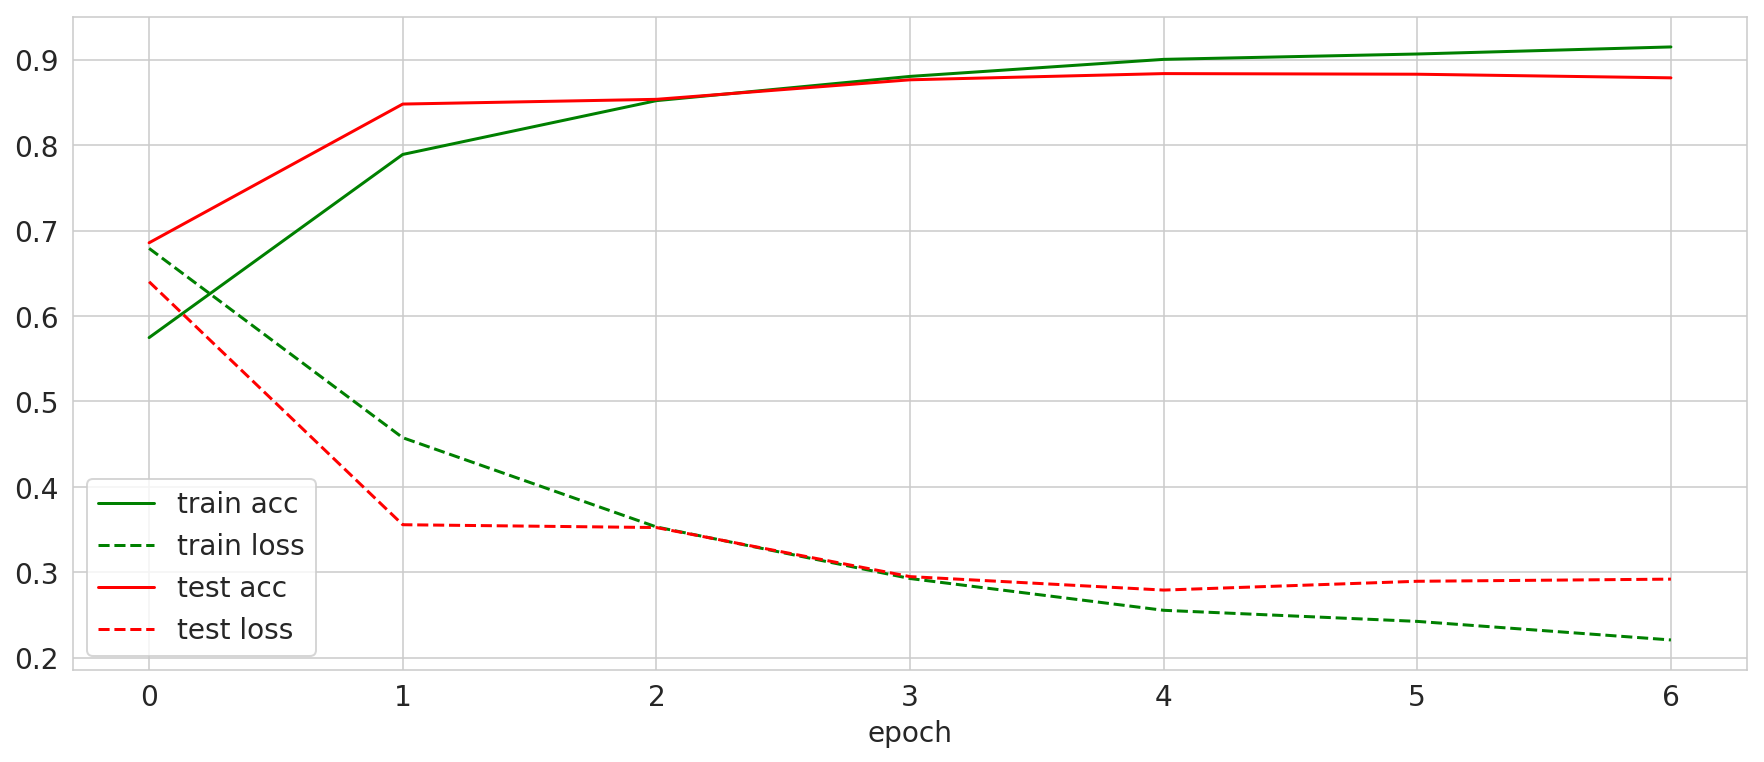

In [100]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(lstm_history.history["acc"], label="train acc", color="green")
ax.plot(lstm_history.history["loss"], label="train loss", color="green", ls="--")
ax.plot(lstm_history.history["val_acc"], label="test acc", color="red")
ax.plot(lstm_history.history["val_loss"], label="test loss", color="red", ls="--")
plt.xlabel("epoch")
plt.legend()
plt.show()

Training has been stopped before overfitting. The best acc obtained during training is 88,375% which is marginally better than SVM TF-IDF.

# LSTM with pretrained embedding layer (word2vec Google news 300dim)

In [0]:
#!gunzip -k /content/gdrive/My\ Drive/data/GoogleNews-vectors-negative300.bin.gz

In [0]:
max_vocab = None
tokenizer = Tokenizer()

In [0]:
tokenizer.fit_on_texts(df_train["review"].values)

In [164]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

100552


In [0]:
X_train = tokenizer.texts_to_sequences(df_train["review"].values)

In [166]:
len(X_train[1])

251

In [167]:
print(len(X_train))

23222


In [168]:
max_length = 300
print(max_length)

300


In [0]:
X_train = pad_sequences(X_train, maxlen=max_length, padding="pre", truncating="pre")

In [170]:
print(X_train.shape)

(23222, 300)


In [171]:
X_train

array([[  327,    56,     1, ...,     4, 15261, 10130],
       [    0,     0,     0, ...,     7,    63,   693],
       [    0,     0,     0, ...,   136,     6,   109],
       ...,
       [    0,     0,     0, ...,    10,    16,  1897],
       [    0,     0,     0, ...,   386,   125,  1461],
       [    0,     0,     0, ...,     5,    74,    79]], dtype=int32)

In [0]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/data/GoogleNews-vectors-negative300.bin', binary=True)  

In [173]:
len(word2vec.vocab)

3000000

In [174]:
word2vec.word_vec("test").shape

(300,)

In [0]:
embedding_size = 300

embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in tokenizer.word_index.items():
  if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)

In [176]:
embedding_matrix.shape

(100552, 300)

In [0]:
y_train = df_train["label"].values

In [178]:
print(y_train.shape)

(23222,)


In [179]:
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [0]:
X_test = tokenizer.texts_to_sequences(df_test["review"].values)

In [181]:
print(len(X_test))

23139


In [0]:
X_test = pad_sequences(X_test, maxlen=max_length, padding="pre", truncating="pre")

In [183]:
print(X_test.shape)

(23139, 300)


In [184]:
X_test

array([[ 2965, 10253, 16655, ...,     2,   582,  4161],
       [    0,     0,     0, ...,   115,    10,    16],
       [    0,     0,     0, ...,    41,     4,   162],
       ...,
       [    0,     0,     0, ...,     4,  1725,   431],
       [    0,     0,     0, ...,    76,     1,   168],
       [    0,     0,     0, ...,   251,     5,   103]], dtype=int32)

In [0]:
y_test = df_test["label"].values

In [186]:
print(y_test.shape)

(23139,)


In [187]:
y_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

## Model declaration

In [188]:
lstm_w2v_model = Sequential()
lstm_w2v_model.add(Embedding(vocab_size, embedding_size, input_length=max_length, weights=[embedding_matrix], trainable=False))
lstm_w2v_model.add(LSTM(128, dropout=0.8))
lstm_w2v_model.add(Dropout(0.5))
lstm_w2v_model.add(Dense(1, activation="sigmoid"))
lstm_w2v_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_w2v_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 300)          30165600  
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 30,385,377
Trainable params: 219,777
Non-trainable params: 30,165,600
_________________________________________________________________


In [0]:
weight_path = "/content/gdrive/My Drive/data/lstm_w2v_best_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.01)
callbacks = [checkpoint, earlystopping]

In [190]:
lstm_w2v_history = lstm_w2v_model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128, validation_data=(X_test, y_test), callbacks=callbacks)

Train on 23222 samples, validate on 23139 samples
Epoch 1/100
23222/23222 [==============================] - 151s 7ms/step - loss: 0.6510 - acc: 0.6103 - val_loss: 0.5036 - val_acc: 0.7812

Epoch 00001: val_acc improved from -inf to 0.78119, saving model to /content/gdrive/My Drive/data/best_weights.hdf5
Epoch 2/100
23222/23222 [==============================] - 150s 6ms/step - loss: 0.6074 - acc: 0.6720 - val_loss: 0.5006 - val_acc: 0.7687

Epoch 00002: val_acc did not improve from 0.78119
Epoch 3/100
23222/23222 [==============================] - 149s 6ms/step - loss: 0.5861 - acc: 0.6919 - val_loss: 0.5042 - val_acc: 0.7545

Epoch 00003: val_acc did not improve from 0.78119
Epoch 4/100
23222/23222 [==============================] - 147s 6ms/step - loss: 0.5706 - acc: 0.7084 - val_loss: 0.4644 - val_acc: 0.7869

Epoch 00004: val_acc improved from 0.78119 to 0.78690, saving model to /content/gdrive/My Drive/data/best_weights.hdf5
Epoch 5/100
23222/23222 [==============================

## Results

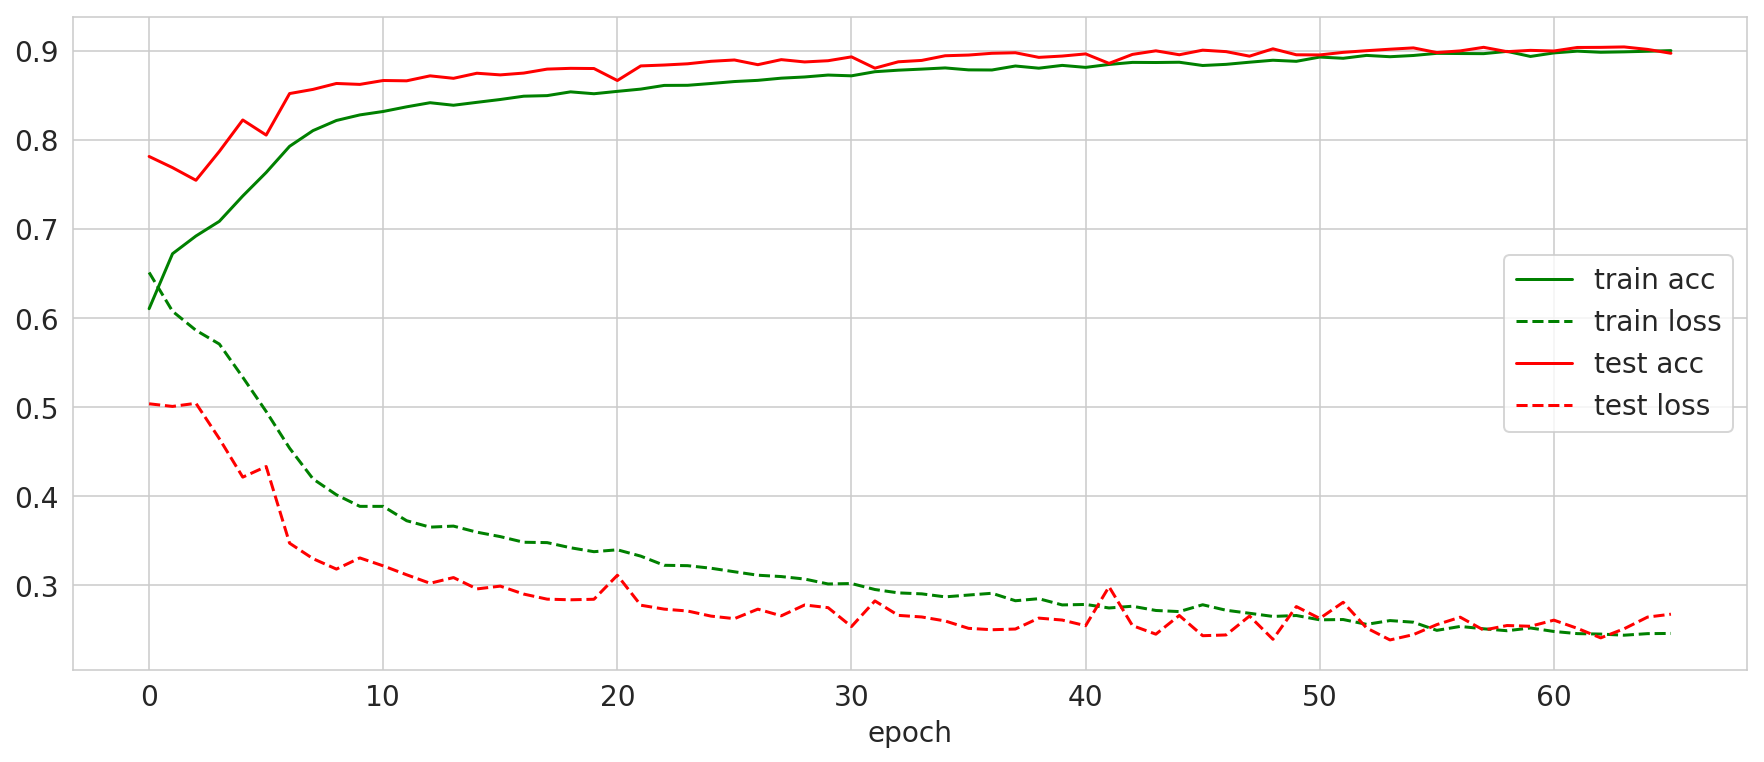

In [191]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(lstm_w2v_history.history["acc"], label="train acc", color="green")
ax.plot(lstm_w2v_history.history["loss"], label="train loss", color="green", ls="--")
ax.plot(lstm_w2v_history.history["val_acc"], label="test acc", color="red")
ax.plot(lstm_w2v_history.history["val_loss"], label="test loss", color=" red", ls="--")
plt.xlabel("epoch")
plt.legend()
plt.show()

Training has been stopped before overfitting. The best score with LSTM pretrained embedding layer is 90,414% which is almost 2% better than SVM and standard LSTM.

# SA-LSTM (WiP)

Work in Progress but currently too long to compute with the available hardware. Based on this publication: https://arxiv.org/pdf/1511.01432.pdf

In [0]:
vocab_size = 10000
embedding_size = 300

sa_lstm_model = Sequential()
sa_lstm_model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
sa_lstm_model.add(LSTM(256))
sa_lstm_model.add(RepeatVector(max_length))
sa_lstm_model.add(LSTM(256, return_sequences=True))
sa_lstm_model.add(TimeDistributed(Dense(1)))
sa_lstm_model.compile(optimizer='adam', loss='mse')
sa_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 300)          3000000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               570368    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 300, 256)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 300, 256)          525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 300, 1)            257       
Total params: 4,095,937
Trainable params: 4,095,937
Non-trainable params: 0
_________________________________________________________________


In [0]:
weight_path = "/content/gdrive/My Drive/data/sa_best_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.01)
callbacks = [checkpoint, earlystopping]

In [0]:
sa_lstm_history = sa_lstm_model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=256, validation_data=(X_test, y_test), callbacks=callbacks)

ValueError: ignored